In [1]:
%cd ..
import os
import time
import json

/home/yongming/apperception


In [2]:
from apperception.database import database
from apperception.world import empty_world
from apperception.utils import F
from apperception.predicate import camera, objects
from optimized_ingestion.utils.preprocess import preprocess
database.connection
from optimized_ingestion.cache import disable_cache
disable_cache()

YOLOv5 🚀 2023-4-10 Python-3.10.6 torch-2.0.0+cu117 CUDA:0 (Tesla T4, 14966MiB)

Using cache found in /home/yongming/apperception/weights/ultralytics_yolov5_master


Using cuda:0


requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable

requirements: 1 package updated per /home/yongming/apperception/weights/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-4-10 Python-3.10.6 torch-2.0.0+cu117 CUDA:0 (Tesla T4, 14966MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [3]:
NUSCENES_PROCESSED_DATA = "NUSCENES_PROCESSED_DATA"
if NUSCENES_PROCESSED_DATA in os.environ:
    DATA_DIR = os.environ[NUSCENES_PROCESSED_DATA]
else:
    DATA_DIR = "/data/processed/full-dataset/trainval"
NUSCENES_RAW_DATA = "NUSCENES_RAW_DATA"
if NUSCENES_RAW_DATA in os.environ:
    RAW_DATA_DIR = os.environ[NUSCENES_RAW_DATA]
else:
    RAW_DATA_DIR = "/data/full-dataset/trainval"

In [4]:
with open('data/evaluation/video-samples/boston-seaport.txt', 'r') as f:
    scenes = f.read().split('\n')

In [2]:
def bechmark_detection_estimation_histogram(video_names=[], scenes=[], path_suffix=None):
    bucket_count = [0] * 10
    bucket_videos = [[]] * 10
    ### detection estimation benchmark
    optimize_benchmark_path = f'./outputs/detection_estimation_histogram{"_"+path_suffix if path_suffix else ""}.json'
#     preprocess(world, DATA_DIR, video_names, scenes,
#                base=False,
#                benchmark_path=optimize_benchmark_path)
    
    with open(optimize_benchmark_path) as benchmark_file:
        benchmark_content = benchmark_file.read()
    
    parsed_json = json.loads(benchmark_content)
    stage_runtimes = parsed_json[0]['stage_runtimes']
    num_videos = parsed_json[2]['number of videos']
    for stage_runtime in stage_runtimes:
        if stage_runtime['stage'] == 'DetectionEstimation':
            for benchmark in stage_runtime['runtimes']:
                keep, _, total = benchmark['keep']
#                 print(benchmark['keep'])
                for i in range(10):
                    if (total-keep)/total >= i*0.1 and (total-keep)/total <= (i+1)*0.1:
                        bucket_count[i] += 1
                        bucket_videos[i].append(benchmark['name'])
    print(bucket_count)
    return bucket_count


In [19]:
name = 'ScenicWorld' # world name
world = empty_world(name=name)

In [5]:
buckets = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4',
           '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8',
           '0.8-0.9', '0.9-1']
all_obj_bucket_count = bechmark_detection_estimation_histogram(scenes=scenes[:200])

[142, 0, 3, 11, 21, 43, 74, 100, 115, 84]


total number of videos 593


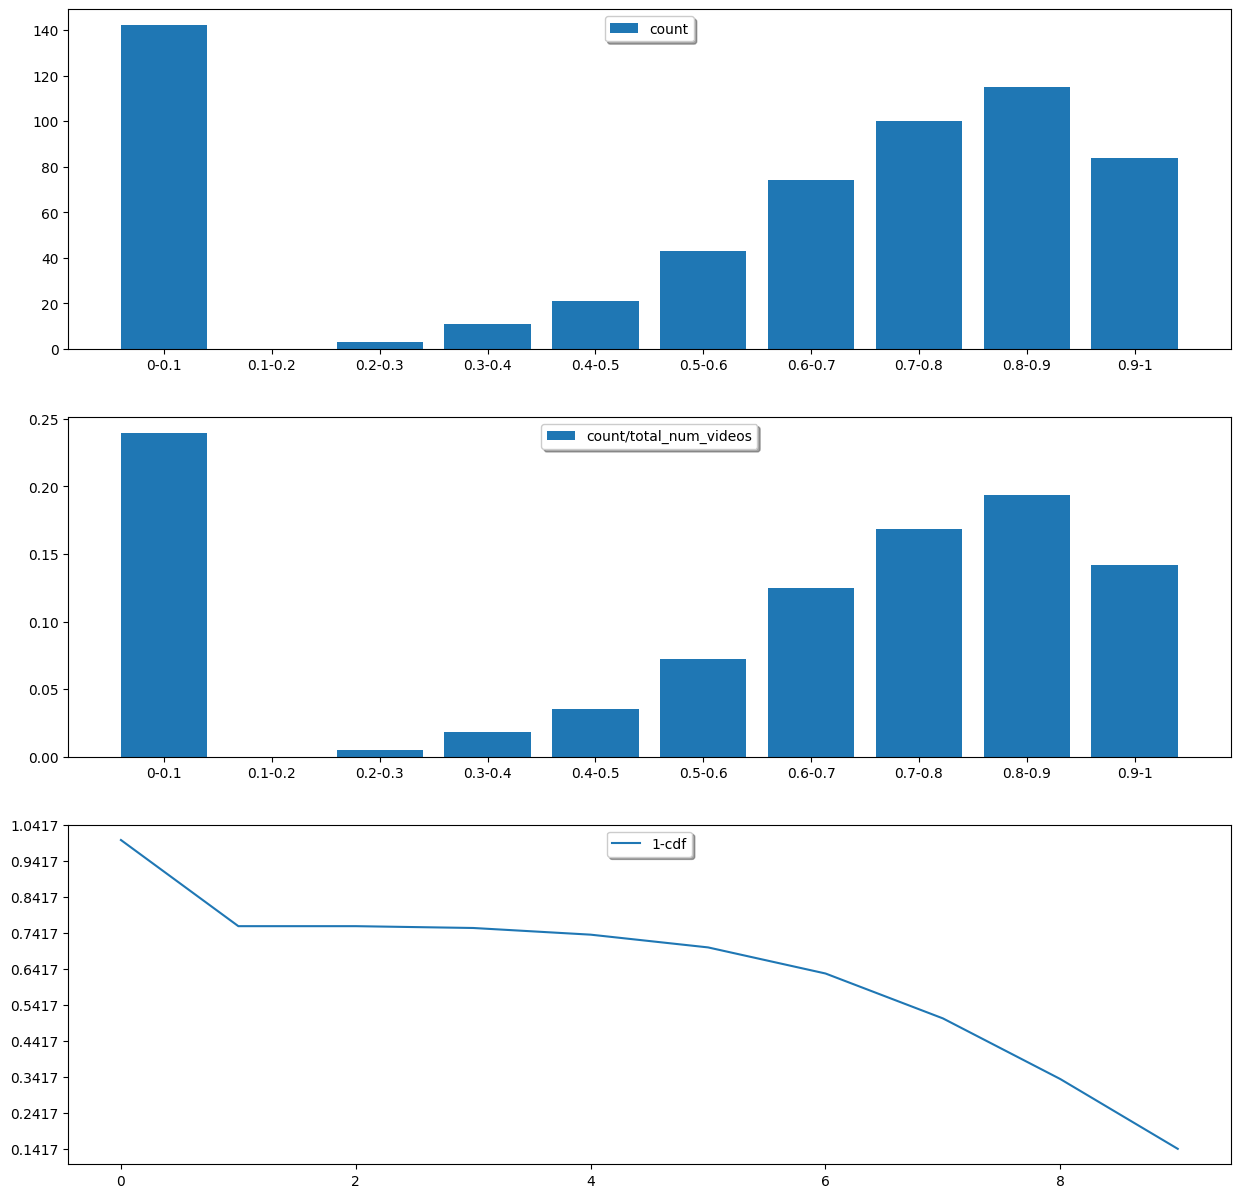

In [7]:
import numpy as np
num_videos = sum(all_obj_bucket_count)
all_obj_count_ratio = [c/num_videos for c in all_obj_bucket_count]
all_obj_count_cdf = [sum([e for e in all_obj_count_ratio[i:]]) for i in range(0, len(all_obj_bucket_count))]
import matplotlib.pyplot as plt
print(f'total number of videos {num_videos}')
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].bar(buckets, all_obj_bucket_count, label="count")
axs[1].bar(buckets, all_obj_count_ratio,  label="count/total_num_videos")
axs[2].plot(range(10), all_obj_count_cdf, label="1-cdf")
for ax in axs:
    ax.legend(loc='upper center', shadow=True)
plt.yticks(np.arange(min(all_obj_count_cdf), max(all_obj_count_cdf) + 0.1, 0.1))
plt.show()

In [22]:
obj1 = objects[0]
cam = camera
car_world = empty_world(name=name).filter(
    (F.like(obj1.type, 'car') | F.like(obj1.type, 'truck') | F.like(obj1.type, 'bus'))
)

In [8]:
only_car_bucket_count = bechmark_detection_estimation_histogram(path_suffix="only_car")

[337, 3, 11, 14, 40, 95, 127, 223, 291, 244]


total number of videos 1385


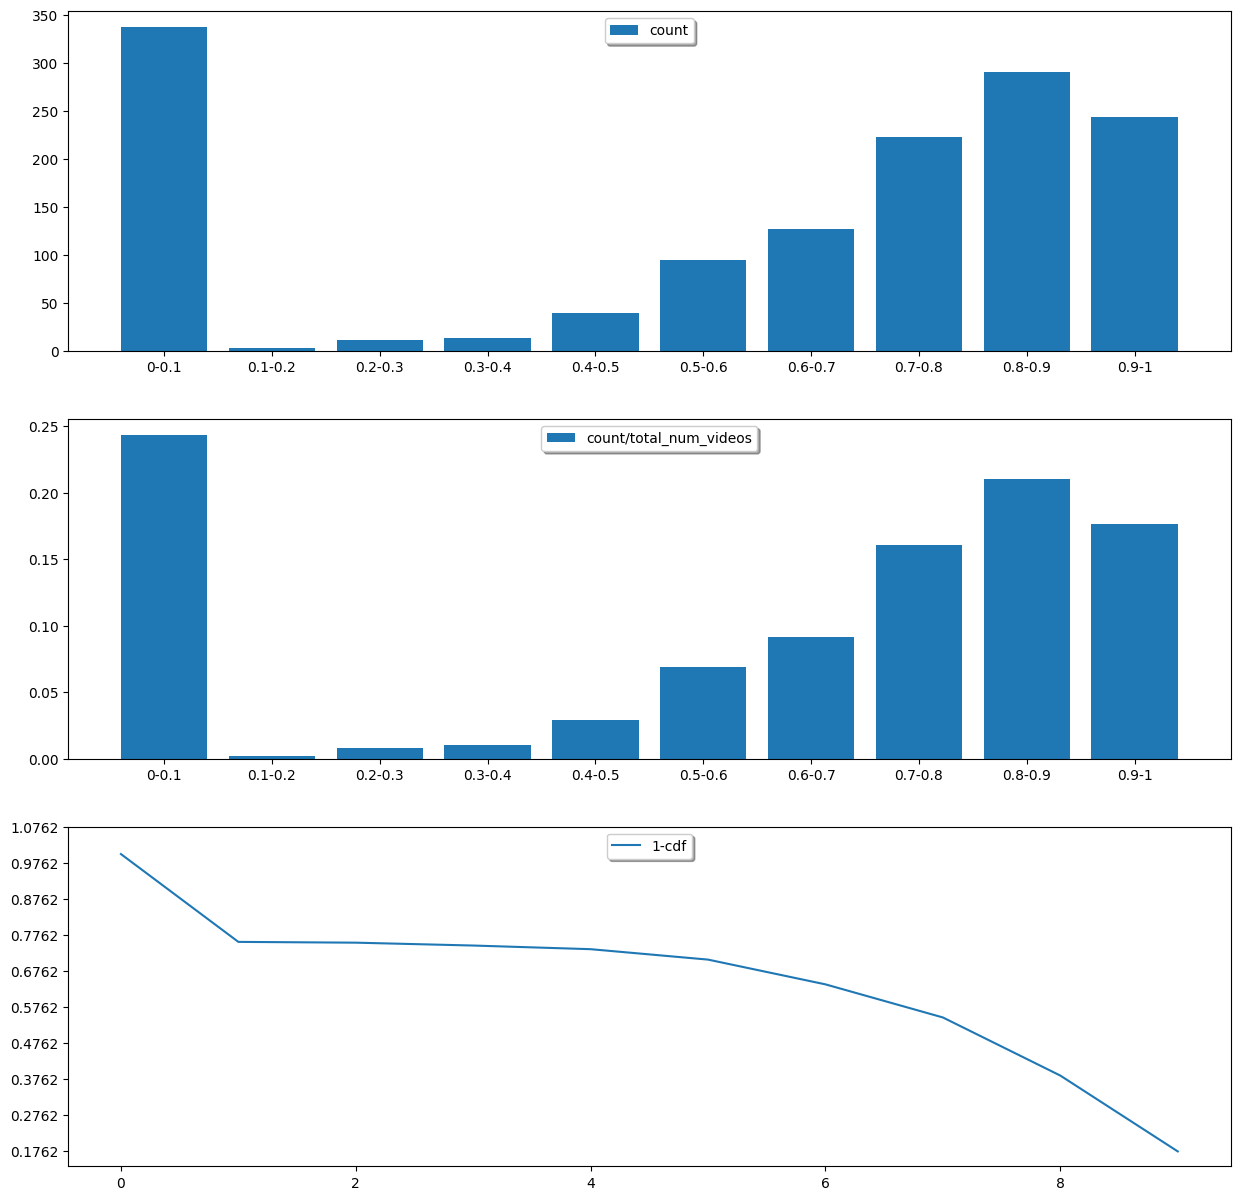

In [13]:
num_videos = sum(only_car_bucket_count)
only_car_count_ratio = [c/num_videos for c in only_car_bucket_count]
only_car_count_cdf = [sum([e for e in only_car_count_ratio[i:]]) for i in range(0, len(only_car_count_ratio))]
import matplotlib.pyplot as plt
print(f'total number of videos {num_videos}')
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].bar(buckets, only_car_bucket_count, label="count")
axs[1].bar(buckets, only_car_count_ratio,  label="count/total_num_videos")
axs[2].plot(range(10), only_car_count_cdf, label="1-cdf")
for ax in axs:
    ax.legend(loc='upper center', shadow=True)
plt.yticks(np.arange(min(only_car_count_cdf), max(only_car_count_cdf)+0.1, 0.1))
plt.show()